In [1]:
CHECKPOINT_PATH = "/home/featurize/work/checkpoint_2_kendall_tau=0.7809.pt"

In [2]:
import torch
import sys
state = torch.load(CHECKPOINT_PATH)
sys.path.insert(0, f"/home/featurize/work/ai4code/_runs/{state['params']['git_commits']}")
from ai4code import models, datasets, metrics, utils

In [3]:
metrics

<module 'ai4code.metrics' from '/home/featurize/work/ai4code/_runs/17aced5895ad01ad44c2959df1804cb9226eadaf/ai4code/metrics.py'>

In [4]:
params = state['params']
dataset_suffix = params['dataset_suffix']
val_folds = params['val_folds']
val_num_samples = params['val_num_samples']
pretrained_path = params['pretrained_path']
extra_vocab = params['extra_vocab']
cell_token_size = params['cell_token_size']
cell_stride = params['cell_stride']
context_cells_token_size = params['context_cells_token_size']
context_stride = params['context_stride']
max_len = params['max_len']
num_workers = params['num_workers']
batch_size = params['batch_size']
dropout = params['dropout']

In [39]:
import pickle
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import random

In [6]:
data = pickle.load(open(f"/home/featurize/work/ai4code/data/fold0.{params['dataset_suffix']}.pkl", "rb"))

In [7]:
val_num_samples = None
val_data = {k: v for k, v in list(data.items()) if v.fold in val_folds}
if val_num_samples is not None:
    val_data = {k: v for k, v in list(val_data.items())[:val_num_samples]}

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_path, do_lower_case=True, use_fast=True
)
if extra_vocab:
    extra_vocab = pickle.load(open(extra_vocab, "rb"))
    tokenizer.add_tokens(x[0] for x in extra_vocab.most_common(2000))

In [9]:
def create_dataset(data):
    return datasets.RankDataset(
        data,
        tokenizer=tokenizer,
        cell_token_size=cell_token_size,
        cell_stride=cell_stride,
        context_cells_token_size=context_cells_token_size,
        context_stride=context_stride,
        max_len=max_len,
    )

val_loader = DataLoader(
    create_dataset(val_data),
    num_workers=num_workers,
    batch_size=batch_size,
)

In [10]:
model = models.Model(pretrained_path, dropout)
if extra_vocab:
    model.backbone.resize_token_embeddings(len(tokenizer))
model.to("cuda")
model.eval()
model.load_state_dict(state['model'])
criterion = torch.nn.L1Loss()

Some weights of the model checkpoint at /home/featurize/distilbert-base-uncased/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
@torch.no_grad()
def rank_eval(engine, batch):
    model.eval()
    ids, mask, targets, cell_numbers = [item.to('cuda') for item in batch[:4]]
    sample_ids, cell_keys = batch[4:]
    scores = model(ids, mask, cell_numbers)
    loss = criterion(scores, targets).item()
    return loss, scores, sample_ids, cell_keys


In [12]:
evaluator = Engine(rank_eval)
ProgressBar().attach(evaluator)
metric = metrics.KendallTauNaive(val_data)
metric.attach(evaluator, "kendall_tau")

In [13]:
_ = evaluator.run(val_loader)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[1/1707]   0%|           [00:00<?]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Kendall Tau:  0.7791757177483314


In [28]:
sample_scores = {}

for sample_id, preds in metric._submission_data.items():
    sample = val_data[sample_id]
    targets = sample.orders
    sample_scores[sample_id] = metrics.kendall_tau([targets], [preds])

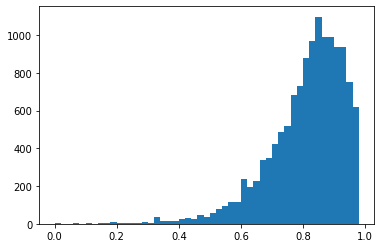

In [37]:
_ = plt.hist(sample_scores.values(), bins=np.arange(0, 1, 0.02))

In [90]:
candinates = {k: v for k, v in sample_scores.items() if v < 0.7}.keys()
key_id = random.sample(candinates, k=1)[0]
sample = val_data[key_id]
print("key: ", key_id, " score: ", sample_scores[key_id])
content_targets = ""
content_preds = ""
sources = ""
wrong_sources = ""

for key in sample.orders:
    content_targets += f"{key}\t{sample.cell_types[key]}\n"

    sources += ">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> " + sample.cell_types[key] + "\n"
    sources += sample.sources[key] + "\n\n\n"

for key in metric._submission_data[sample.id]:
    content_preds += f"{key}\t{sample.cell_types[key]}\n"

    wrong_sources += ">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> " + sample.cell_types[key] + "\n"
    wrong_sources += sample.sources[key] + "\n\n\n"

key:  69820fe579379e  score:  0.42690058479532167


In [91]:
open("/tmp/1", "w").write(content_targets)
open("/tmp/2", "w").write(content_preds)
open("/tmp/source", "w").write(sources)
open("/tmp/wrong_source", "w").write(wrong_sources)

4520

In [81]:
!diff -y /tmp/1 /tmp/2 > /tmp/3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
